In [5]:
# Load getdist and plot chains from Cobaya output
from getdist import MCSamples, plots, loadMCSamples
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

complexity = 6
# Use a predefined runname from the ESR library that includes sine functions
runname = "core_maths"
potential_function_index = 48  # Index of the ESR function to use
chain_root = f'./chains/camb_esr_{runname}_compl_{complexity}_{potential_function_index}'

samples_tab = loadMCSamples(chain_root,settings={'ignore_rows': 0.33})

print('Parameter names available:', samples_tab.getParamNames().list())
# print('Parameter names available:', samples_direct.getParamNames().list())


./chains/camb_esr_core_maths_compl_6_48.4.txt
./chains/camb_esr_core_maths_compl_6_48.1.txt
./chains/camb_esr_core_maths_compl_6_48.3.txt
./chains/camb_esr_core_maths_compl_6_48.2.txt
Removed 0.33 as burn in
Parameter names available: ['omch2', 'ombh2', 'H0', 'a0', 'chi2__BAO', 'chi2__CMB', 'chi2__SN', 'chi2_total', 'omegam', 'rdrag', 'hrd', 'thetastar', 'chi2', 'chi2__cmb_lite_3d', 'chi2__bao.desi_dr2.desi_bao_all', 'chi2__sn.union3']


Saving triangle plot to mcmc_triangle.pdf


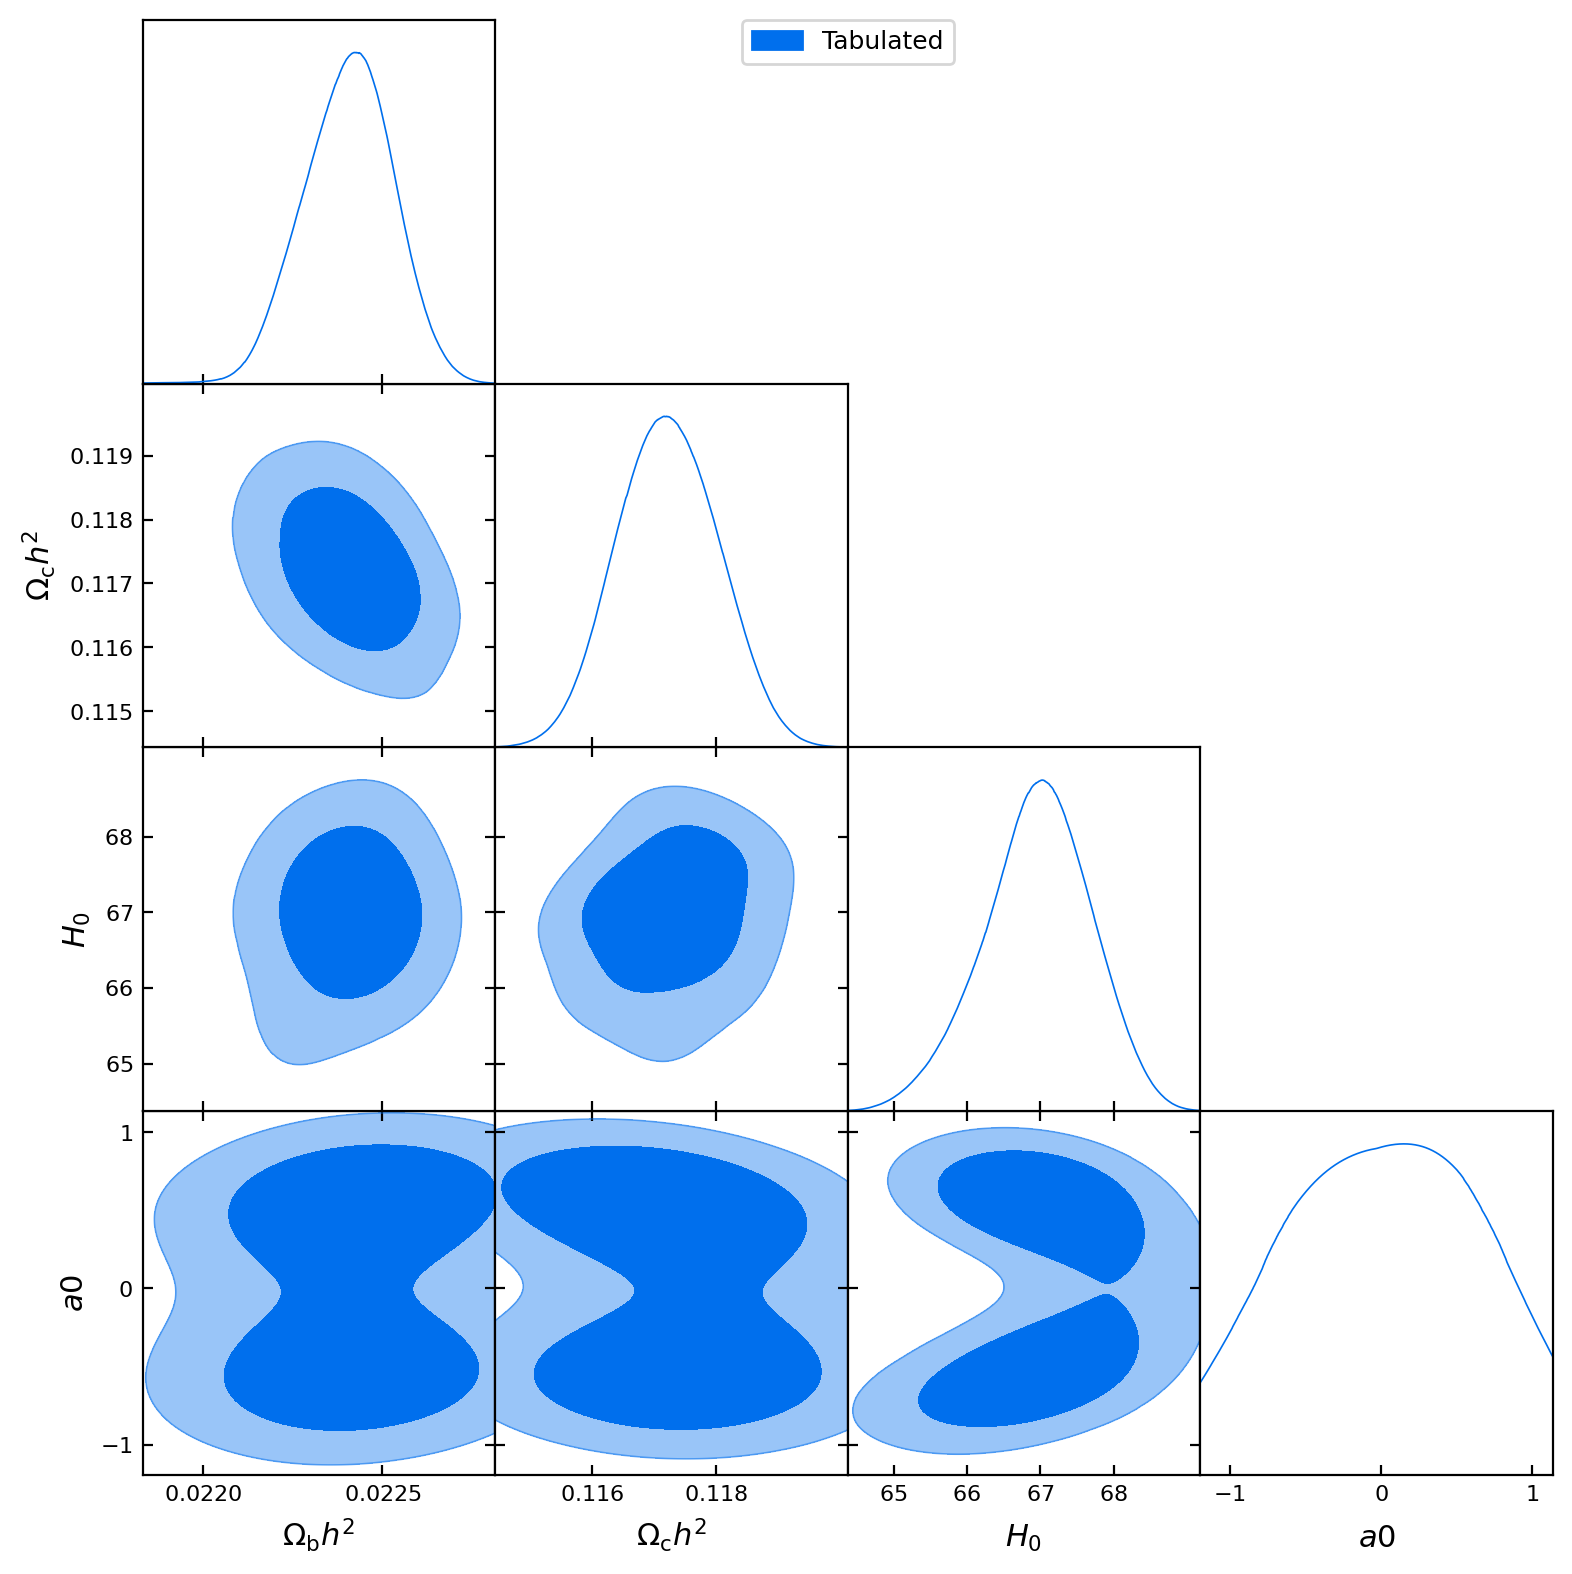

In [6]:
param_names = ['ombh2', 'omch2', 'H0','a0']

g = plots.getSubplotPlotter()
g.triangle_plot([samples_tab], param_names, filled=True,legend_labels=['Tabulated', 'Direct']) #,param_limits=param_limits)
out_triangle = 'mcmc_triangle.pdf'
print('Saving triangle plot to', out_triangle)
# g.export(out_triangle)


# for p in param_names:
#     print(samples.getInlineLatex(p,limit=2))

# # 1D marginals for each parameter separately
# for pname in samples.getParamNames().list():
#     name = pname.name
#     g = plots.getSinglePlotter()
#     g.plot_1d(samples, [name])
#     out1d = f'mcmc_1d_{name}.png'
#     print('Saving 1D marginal to', out1d)
#     g.export(out1d)


In [7]:
# Plot the potential

from CambPotential.esr_utils import load_esr_function_string, create_potential_table
esr_functions_file = f'./CambPotential/esrfunctions/{runname}/compl_{complexity}/unique_equations_{complexity}.txt'
esr_function_string, esr_function_template, esr_param_symbols = load_esr_function_string(esr_functions_file, potential_function_index)
esr_param_names = [str(p) for p in esr_param_symbols]



Loaded ESR function: x*(a0 - x) with parameters: ['a0']


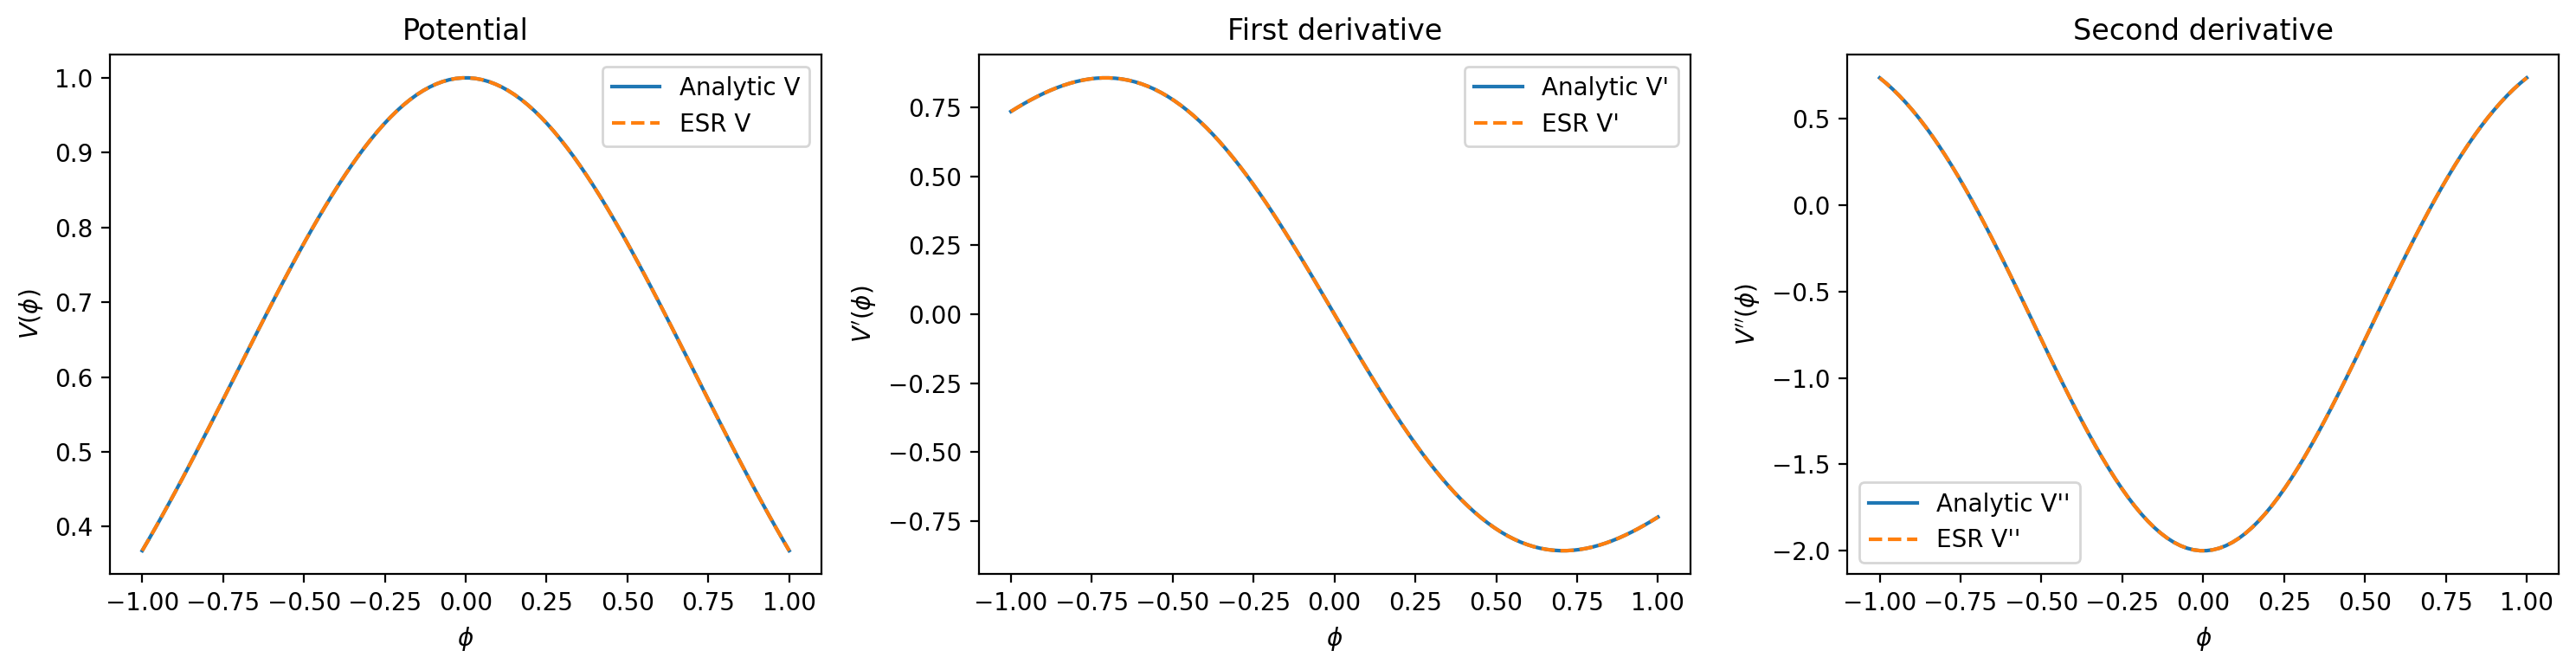

In [9]:
phi_vals = np.linspace(-1, 1, 100)
# Analytic
potential_vals = np.exp(-phi_vals**2)
potential1_vals = -2 * phi_vals * np.exp(-phi_vals**2)
potential2_vals = (4 * phi_vals**2 - 2) * np.exp(-phi_vals**2)

# ESR
esr_results_dict = create_potential_table(esr_function_template, esr_param_symbols, [0.], phi_vals)
potential_vals_esr = esr_results_dict['V_train']
potential1_vals_esr = esr_results_dict['dV_train']
potential2_vals_esr = esr_results_dict['ddV_train']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(phi_vals, potential_vals, label='Analytic V')
axes[0].plot(phi_vals, potential_vals_esr, label='ESR V', linestyle='--')
axes[0].set_xlabel(r'$\phi$')
axes[0].set_ylabel(r'$V(\phi)$')
axes[0].set_title('Potential')
axes[0].legend()

axes[1].plot(phi_vals, potential1_vals, label="Analytic V'")
axes[1].plot(phi_vals, potential1_vals_esr, label="ESR V'", linestyle='--')
axes[1].set_xlabel(r'$\phi$')
axes[1].set_ylabel(r"$V'(\phi)$")
axes[1].set_title("First derivative")
axes[1].legend()

axes[2].plot(phi_vals, potential2_vals, label="Analytic V''")
axes[2].plot(phi_vals, potential2_vals_esr, label="ESR V''", linestyle='--')
axes[2].set_xlabel(r'$\phi$')
axes[2].set_ylabel(r"$V''(\phi)$")
axes[2].set_title("Second derivative")
axes[2].legend()

plt.tight_layout()
plt.show()